In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Adam Optimizer: A Detailed Implementation and Analysis

## Scratch implementation for Adam Optimizer

In [ ]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m = None # set the first moment vector
        self.v = None # set the second moment vector
        self.t = 0 # timestep
        self.beta1 = beta1 # exponential decay rate for the first moment estimates.
        self.beta2 = beta2 # exponential decay rate for the second moment estimates.
        self.epsilon = epsilon # small constant
        self.learning_rate = learning_rate # initial learning rate.


    def update(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * np.square(grads)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        updated_params = params - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return updated_params

In [ ]:
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops
from keras import ops


class CustomAdam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7, **kwargs):
        super().__init__(learning_rate=learning_rate,**kwargs)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def build(self, variables):
        super().build(variables)
        self.ms = []
        self.vs = []
        for variable in variables:
            self.ms.append(
                self.add_variable_from_reference(
                    reference_variable=variable, name="m"
                )
            )
            self.vs.append(
                self.add_variable_from_reference(
                    reference_variable=variable, name="v"
                )
            )

    def update_step(self, gradient, variable, learning_rate):
        learning_rate = math_ops.cast(learning_rate, variable.dtype)
        gradient = math_ops.cast(gradient, variable.dtype)

        m = self.ms[self._get_variable_index(variable)]
        v = self.vs[self._get_variable_index(variable)]

        self.assign(m, self.beta1 * m + (1 - self.beta1) * gradient)
        self.assign(v, self.beta2 * v + (1 - self.beta2) * math_ops.square(gradient))

        t = math_ops.cast(self.iterations + 1, variable.dtype)
        m_hat = m / (1 - math_ops.pow(self.beta1, t))
        v_hat = v / (1 - math_ops.pow(self.beta2, t))

        self.assign_sub(variable, learning_rate * m_hat / (math_ops.sqrt(v_hat) + self.epsilon))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "learning_rate": self.learning_rate,
                "beta1": self.beta1,
                "beta2": self.beta2,
                "epsilon": self.epsilon,
            }
        )
        return config

# **Load and preprocess MNIST dataset**


In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# **Model architectures**

In [ ]:
def create_simple_nn():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# **Training function with additional metrics**


In [ ]:
def train_and_evaluate(model, optimizer, loss_fn, train_data, train_labels,
                      test_data, test_labels, epochs, batch_size):
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # This tracking of training time
    start_time = time.time()
    history = model.fit(train_data, train_labels, epochs=epochs,
                       batch_size=batch_size, validation_split=0.2, verbose=1)
    training_time = time.time() - start_time

    # For evaluating on test set
    test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

    return {
        'history': history.history,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'training_time': training_time
    }

# **Experiment configurations**


In [ ]:
configs = {
    'SimpleNN_KerasAdam': {
        'model': create_simple_nn(),
        'optimizer': optimizers.Adam(learning_rate=0.001)
    },
    'SimpleNN_CustomAdam': {
        'model': create_simple_nn(),
        'optimizer': CustomAdam(learning_rate=0.001)
    },
    'CNN_KerasAdam': {
        'model': create_cnn(),
        'optimizer': optimizers.Adam(learning_rate=0.001)
    },
    'CNN_CustomAdam': {
        'model': create_cnn(),
        'optimizer': CustomAdam(learning_rate=0.001)
    }
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Run experiments**

In [ ]:
results = {}
for name, config in configs.items():
    print(f"\nTraining {name}")
    results[name] = train_and_evaluate(
        config['model'],
        config['optimizer'],
        tf.keras.losses.CategoricalCrossentropy(),
        train_images, train_labels,
        test_images, test_labels,
        epochs=5, batch_size=64
    )


Training SimpleNN_KerasAdam
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8329 - loss: 0.5646 - val_accuracy: 0.9545 - val_loss: 0.1609
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9571 - loss: 0.1401 - val_accuracy: 0.9649 - val_loss: 0.1183
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9738 - loss: 0.0869 - val_accuracy: 0.9664 - val_loss: 0.1105
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9800 - loss: 0.0657 - val_accuracy: 0.9719 - val_loss: 0.0958
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9856 - loss: 0.0482 - val_accuracy: 0.9712 - val_loss: 0.0986

Training SimpleNN_CustomAdam
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8425 - loss: 0.5498 - val_accuracy: 0.9568 - val_loss: 0.1479
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9592 - loss: 0.1387 - val_accuracy: 0.9658 - val_loss: 0.1142
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

# **Visualization functions**

In [ ]:
def plot_training_metrics(results, metric='loss'):
    plt.figure(figsize=(12, 6))
    for name, result in results.items():
        plt.plot(result['history'][metric], label=f'{name} (train)')
        plt.plot(result['history'][f'val_{metric}'], label=f'{name} (val)')
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_performance_comparison(results):
    metrics = ['test_accuracy', 'test_loss', 'training_time']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics):
        values = [result[metric] for result in results.values()]
        names = list(results.keys())

        ax = axes[i]
        sns.barplot(x=names, y=values, ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_xticklabels(names, rotation=45)

    plt.tight_layout()
    plt.show()

# **Generate visualizations**


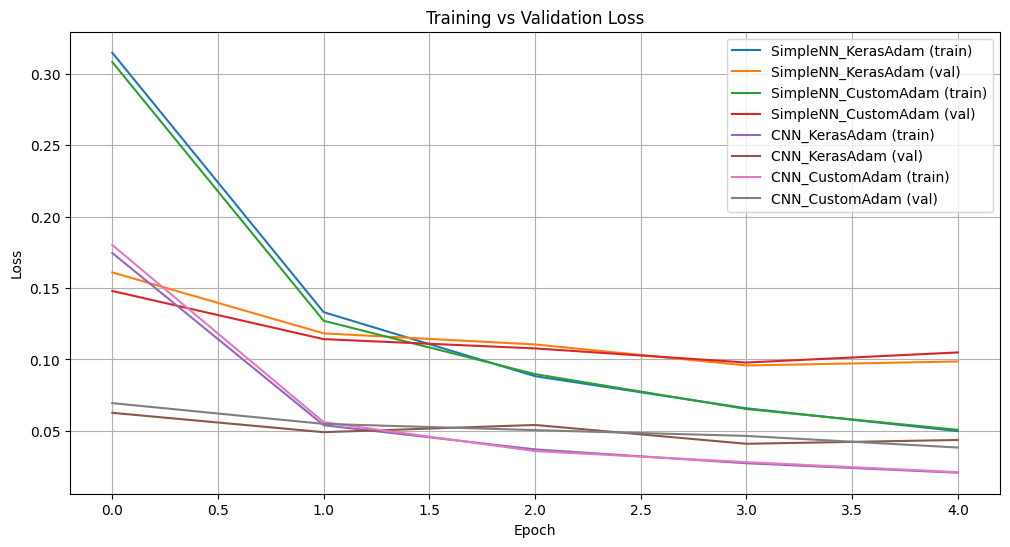

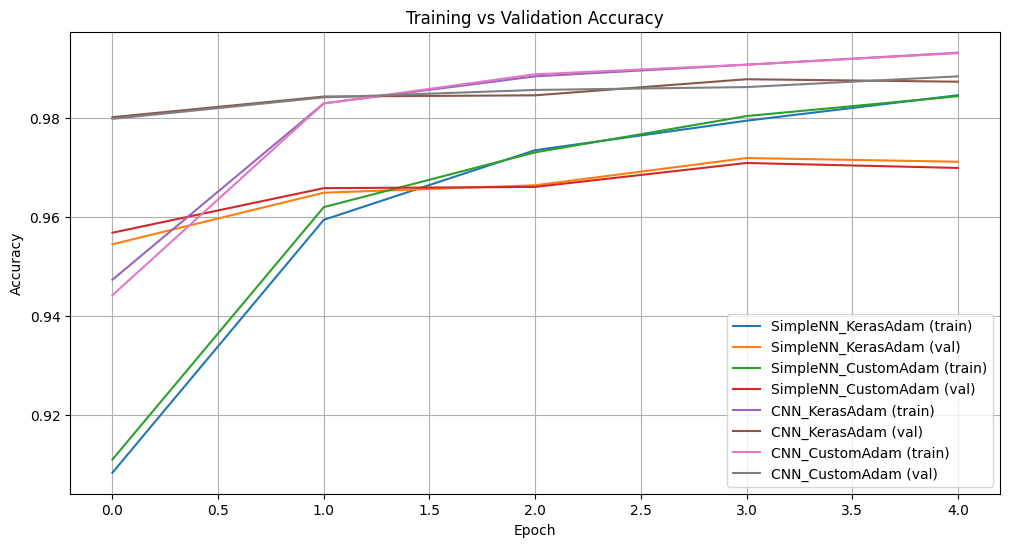

<ipython-input-12-5e5212c436e1>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45)
<ipython-input-12-5e5212c436e1>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45)
<ipython-input-12-5e5212c436e1>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45)


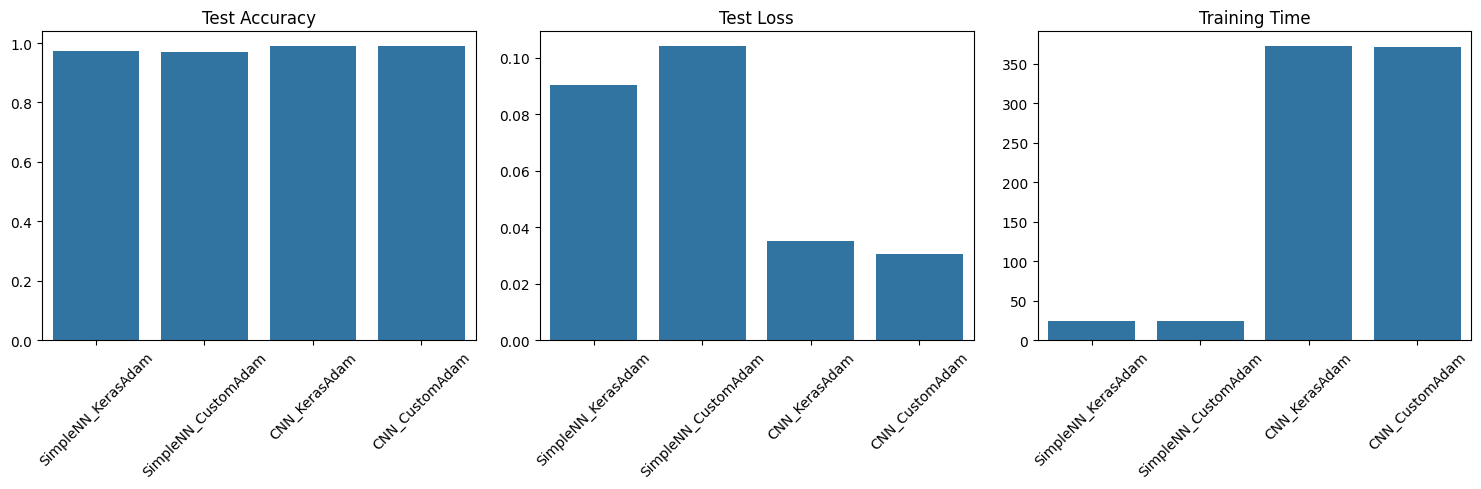

In [ ]:
plot_training_metrics(results, 'loss')
plot_training_metrics(results, 'accuracy')
plot_performance_comparison(results)

# **Analysis summary**

In [ ]:
def print_analysis_summary(results):
    print("\nPerformance Analysis Summary:")
    print("-" * 50)

    # test accuracy comparison
    accuracies = {name: result['test_accuracy'] for name, result in results.items()}
    best_accuracy = max(accuracies.items(), key=lambda x: x[1])
    print(f"\nBest Test Accuracy: {best_accuracy[0]} ({best_accuracy[1]:.4f})")

    # training time comparison
    times = {name: result['training_time'] for name, result in results.items()}
    fastest = min(times.items(), key=lambda x: x[1])
    print(f"Fastest Training: {fastest[0]} ({fastest[1]:.2f}s)")

    # convergence analysis
    print("\nConvergence Analysis:")
    for name, result in results.items():
        final_loss = result['history']['loss'][-1]
        loss_improvement = result['history']['loss'][0] - final_loss
        if name.startswith('CNN_KerasAdam'):
            print("="*50)
        print(f"{name}: Final loss = {final_loss:.4f}, Total improvement = {loss_improvement:.4f}")

print_analysis_summary(results)


Performance Analysis Summary:
--------------------------------------------------

Best Test Accuracy: CNN_KerasAdam (0.9899)
Fastest Training: SimpleNN_CustomAdam (24.23s)

Convergence Analysis:
SimpleNN_KerasAdam: Final loss = 0.0498, Total improvement = 0.2649
SimpleNN_CustomAdam: Final loss = 0.0507, Total improvement = 0.2575
CNN_KerasAdam: Final loss = 0.0207, Total improvement = 0.1538
CNN_CustomAdam: Final loss = 0.0211, Total improvement = 0.1590
